# Predict Amazon daily stock price
1 Liner modal
2 kNN
3 Random forest regressor
4 Long Short Term Memory (LSTM)
5 Auto-ARIMA
6 Prophet

#Get stock data from Yahoo finance

In [68]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce

def getStockData():
    tickers = []

    tickers.append('AMZN')

    # indexs
    tickers.extend(['^DJI', '^GSPC', '^NDX'])
    
    # Treasury Yield
    tickers.extend(['^IRX', '^FVX', '^TNX', '^TYX'])

    # other companies
    tickers.extend(['AAPL', 'FB', 'GOOG', 'NFLX', 'EBAY', 'CRM', 'MSFT', 'WMT'])
    
    # other countries index
    tickers.extend(['000001.SS', '^HSI', '^N225', '^FCHI', '^GDAXI',  '^BSESN'])

    start_date = '2008-8-8'
    end_date = '2016-7-1'

    frames = []
    for ticker in tickers:
        stock_data = data.DataReader(ticker, 'yahoo', start_date, end_date)
        stock_data = stock_data.rename(lambda s: (s.lower() + '-' + ticker).replace(' ', '-'), axis='columns')
        frames.append(stock_data)

    df_final = reduce(lambda left,right: left.join(right), frames)
    
    df_final.to_csv('stockData2.csv')
    
#getStockData()

In [69]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# read the data
# FullStockNew.csv: has news info
# stockData2.csv: no news info
isNews = True
filename = isNews and 'FullStockNew.csv' or 'stockData2.csv'
df = pd.read_csv(filename)

df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

# drop Invalid Date
df = df[~df.index.isin(['NaT'])]
    
data = df.sort_index(ascending=True, axis=0)

In [70]:
print ('Shape:', data.shape)
data.head()

Shape: (1983, 173)


,0,1,2,3,4,5,6,7,8,9,...,open-^GDAXI,close-^GDAXI,volume-^GDAXI,adj-close-^GDAXI,high-^BSESN,low-^BSESN,open-^BSESN,close-^BSESN,volume-^BSESN,adj-close-^BSESN
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6537.540039,6561.649902,144950800.0,6561.649902,15228.820312,14888.120117,15036.570312,15167.820312,21000.0,15167.820312
2008-08-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6570.520020,6609.629883,123059300.0,6609.629883,15520.709961,15367.969727,15430.309570,15503.919922,26200.0,15503.919922
2008-08-12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6601.700195,6585.870117,121877700.0,6585.870117,15579.780273,15124.910156,15577.200195,15212.129883,27000.0,15212.129883
2008-08-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6562.970215,6422.189941,165121000.0,6422.189941,15272.559570,15013.059570,15030.209961,15093.120117,19200.0,15093.120117
2008-08-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6450.729980,6442.209961,125922600.0,6442.209961,15033.280273,14686.660156,15017.679688,14724.179688,22000.0,14724.179688


In [71]:
add_datepart = True

import re
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    if drop: df.drop(fldname, axis=1, inplace=True)

# Add year, month, week, day & date related information
if add_datepart:
    add_datepart(data, 'Date')
else:
    data.drop('Date', axis=1, inplace=True)
    

In [72]:
# Move adj-close-AMZN to the last
cols = list(data.columns.values)
cols.pop(cols.index('adj-close-AMZN')) 
data = data[cols+['adj-close-AMZN']]

In [73]:
print ('Shape:', data.shape)
data.head()

Shape: (1983, 184)


,0,1,2,3,4,5,6,7,8,9,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,adj-close-AMZN
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8,4,221,False,False,False,False,False,False,80.510002
2008-08-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11,0,224,False,False,False,False,False,False,88.089996
2008-08-12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12,1,225,False,False,False,False,False,False,87.250000
2008-08-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13,2,226,False,False,False,False,False,False,86.690002
2008-08-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14,3,227,False,False,False,False,False,False,88.029999


In [74]:
train_len = int(len(data) * 0.75)

# drop amzn related data
dropColumns = ['high-AMZN', 'low-AMZN', 'open-AMZN', 'close-AMZN']
for column in dropColumns:
    if column in data.columns:
        data.drop(column, axis=1, inplace=True)
    

# fill the na using previous rows
data.fillna(method='ffill', inplace=True)
# in case the first row data is invalid
data.fillna(method='bfill', inplace=True)

# drop all zero data
data = data.loc[:, (data != 0).any(axis=0)]
print ('data shape:', data.shape)
data.head()

data shape: (1983, 175)


,0,1,2,3,4,5,6,7,8,9,...,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,adj-close-AMZN
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32,8,4,221,False,False,False,False,False,80.510002
2008-08-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,33,11,0,224,False,False,False,False,False,88.089996
2008-08-12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,33,12,1,225,False,False,False,False,False,87.250000
2008-08-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,33,13,2,226,False,False,False,False,False,86.690002
2008-08-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,33,14,3,227,False,False,False,False,False,88.029999


In [75]:
train = data[:train_len]
valid = data[train_len:]

train_1 = train.copy()
valid_1 = valid.copy()

x_train = train_1.drop('adj-close-AMZN', axis=1)
y_train = train_1['adj-close-AMZN']
x_valid = valid_1.drop('adj-close-AMZN', axis=1)
y_valid = valid_1['adj-close-AMZN']

#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)


print(train.shape, valid.shape, x_train[0:2])

(1487, 175) (496, 175)    0    1    2    3    4    5    6    7    8    9   ...        164       165  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.636364  0.596154   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.636364  0.615385   

        166  167       168  169  170  171  172  173  
0  0.233333  1.0  0.601648  0.0  0.0  0.0  0.0  0.0  
1  0.333333  0.0  0.609890  0.0  0.0  0.0  0.0  0.0  

[2 rows x 174 columns]


/Users/yanjingding/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/yanjingding/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


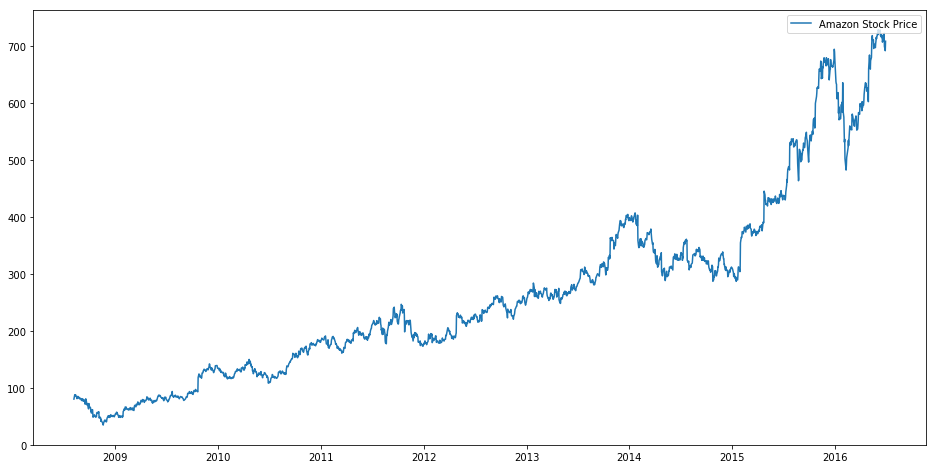

In [76]:
#plot
plt.figure(figsize=(16,8))
plt.plot(data['adj-close-AMZN'], label='Amazon Stock Price')

plt.legend(loc = 'upper right')

# Liner_model to predict stock prices

In [77]:
#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [78]:
#make predictions and find the rmse
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

244.96293421088387

In [79]:
valid.head()

,0,1,2,3,4,5,6,7,8,9,...,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,adj-close-AMZN
Date,,,,,,,,,,,,,,,,,,,,,
2014-07-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,28,11,4,192,False,False,False,False,False,346.200012
2014-07-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29,14,0,195,False,False,False,False,False,355.320007
2014-07-15,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29,15,1,196,False,False,False,False,False,354.440002
2014-07-16,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29,16,2,197,False,False,False,False,False,355.899994
2014-07-17,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29,17,3,198,False,False,False,False,False,352.450012


/Users/yanjingding/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/yanjingding/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


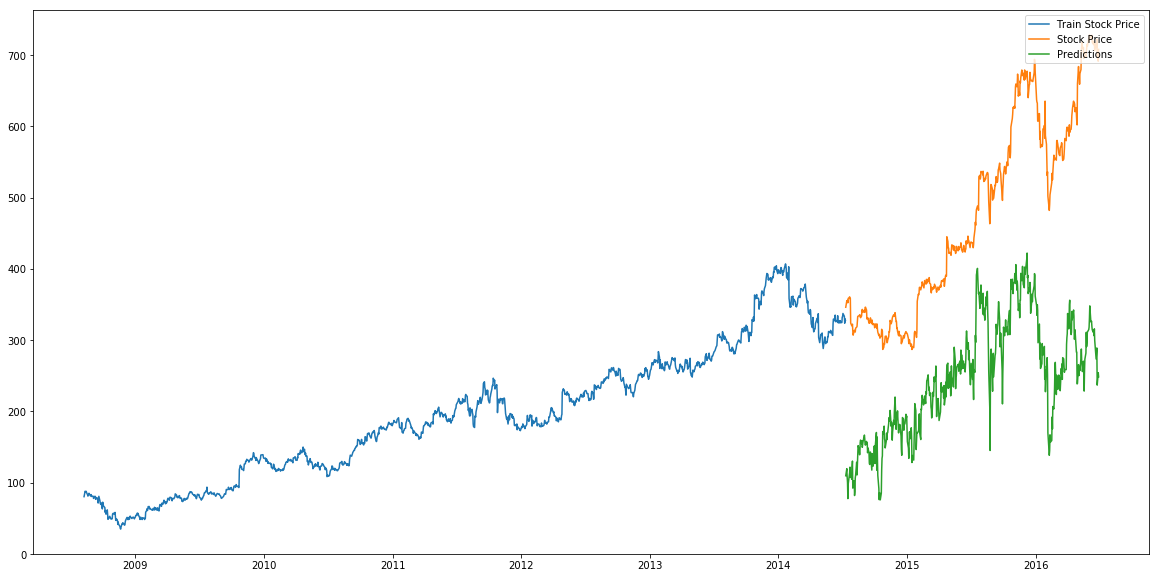

In [81]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds

valid.index = data[train_len:].index
train.index = data[:train_len].index


plt.plot(train['adj-close-AMZN'], label='Train Stock Price')
plt.plot(valid['adj-close-AMZN'], label='Stock Price')
plt.plot(valid['Predictions'], label='Predictions')
plt.legend(loc='upper right')


# Use kNN to predict stock price

In [82]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)


/Users/yanjingding/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [83]:
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

286.9181260776525

/Users/yanjingding/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/yanjingding/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


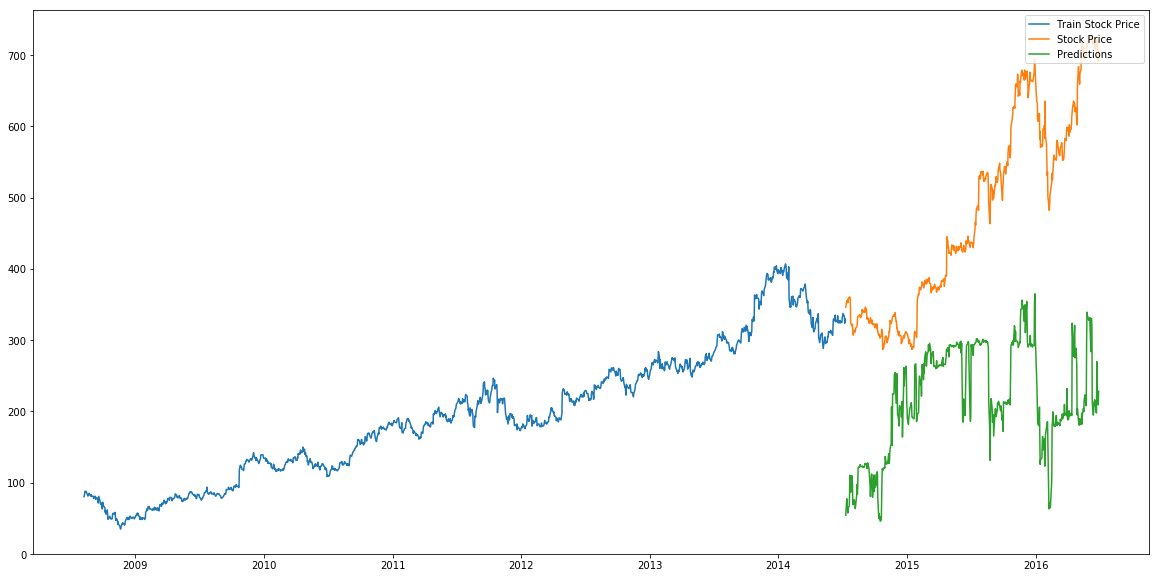

In [84]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds

plt.plot(train['adj-close-AMZN'], label='Train Stock Price')
plt.plot(valid['adj-close-AMZN'], label='Stock Price')
plt.plot(valid['Predictions'], label='Predictions')
plt.legend(loc='upper right')


# Use Random forest to predict stock price

In [85]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score,f1_score

model = RandomForestRegressor(n_jobs = -1, n_estimators = 10,
                                 bootstrap = True)


In [86]:
model.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [87]:
preds = model.predict(x_valid)

In [88]:
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

295.06148663757403

/Users/yanjingding/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/yanjingding/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


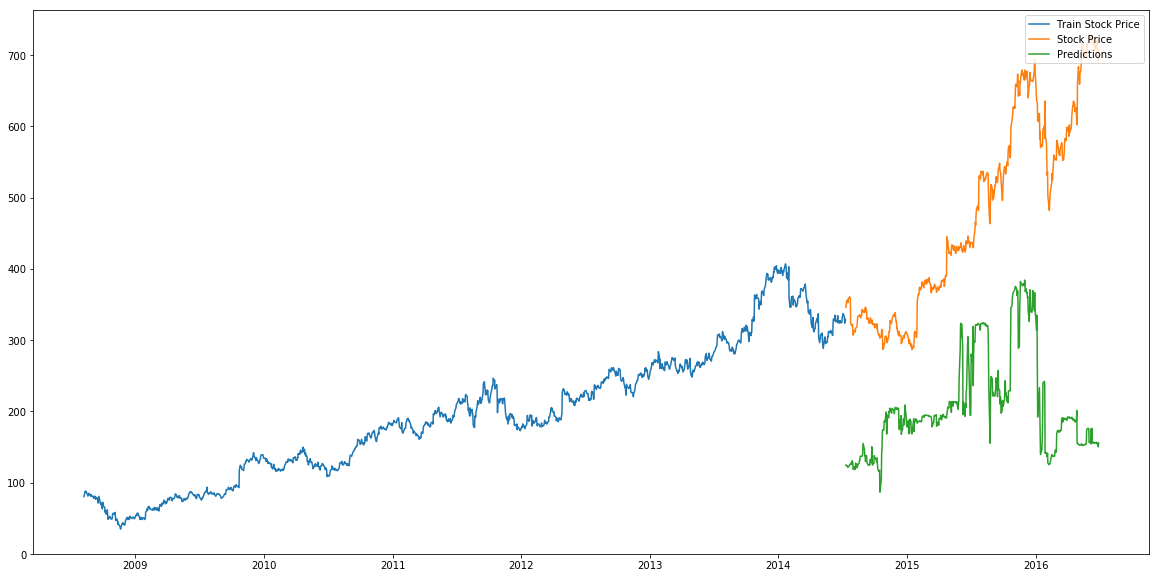

In [89]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds

plt.plot(train['adj-close-AMZN'], label='Train Stock Price')
plt.plot(valid['adj-close-AMZN'], label='Stock Price')
plt.plot(valid['Predictions'], label='Predictions')
plt.legend(loc='upper right')


# LSTM to predict

In [9]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

new_data2 = pd.DataFrame(index=range(0,len(data)),columns=['Close'])
for i in range(0,len(data)):
    new_data2['Close'][i] = data['adj-close-AMZN'][i]

#creating train and test sets
dataset = new_data2.values

train = dataset[0:train_len,:]
valid = dataset[train_len:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train_1, y_train_1 = [], []
for i in range(5,len(train)):
    x_train_1.append(scaled_data[i-5:i,0])
    y_train_1.append(scaled_data[i,0])
x_train_1, y_train_1 = np.array(x_train_1), np.array(y_train_1)

print (scaled_data.shape)

/Users/yanjingding/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(1983, 1)


/Users/yanjingding/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [16]:
x_train_1 = np.reshape(x_train_1, (x_train_1.shape[0],x_train_1.shape[1],1))

In [17]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_1.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
#predicting values, using past 5 from the train data
model.fit(x_train_1, y_train_1, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 33s - loss: 5.7769e-04


In [18]:
inputs = new_data2[len(new_data2) - len(valid) - 5:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(5,inputs.shape[0]):
    X_test.append(inputs[i-5:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

Close    39.699753
dtype: float64

/Users/yanjingding/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


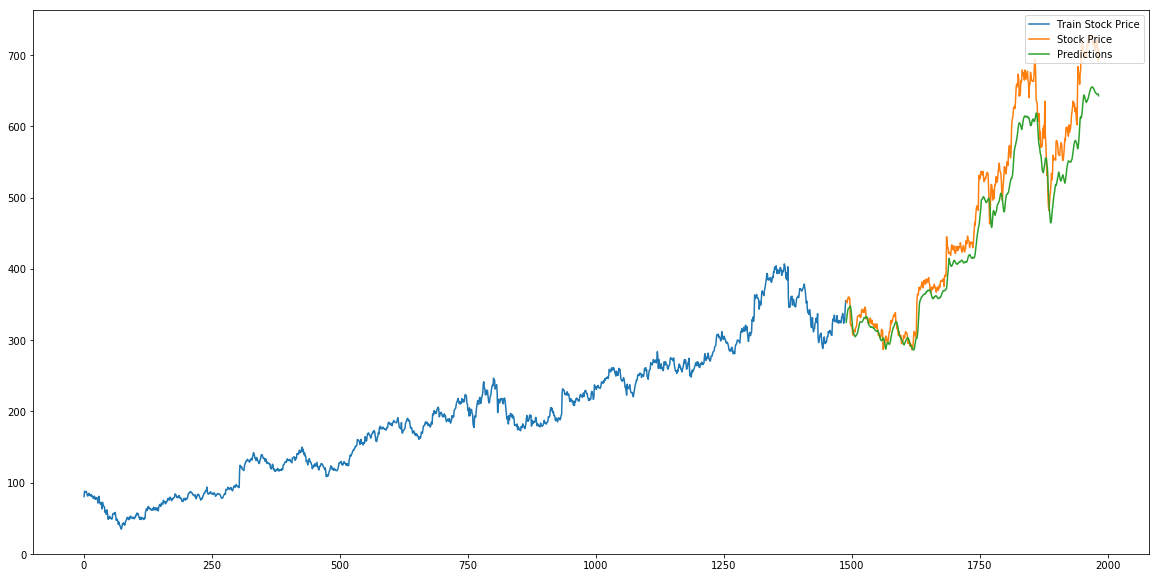

In [37]:
#for plotting
train = new_data2[:train_len]
valid = new_data2[train_len:]
valid['Predictions'] = closing_price
plt.plot(train['Close'], label='Train Stock Price')
plt.plot(valid['Close'], label='Stock Price')
plt.plot(valid['Predictions'], label='Predictions')
plt.legend(loc='upper right')

# Use auto ARIMA

In [44]:
from pyramid.arima import auto_arima

training = train['Close']
validation = valid['Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=len(validation))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=8668.485, BIC=8694.970, Fit time=4.473 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=9678.171, BIC=9688.765, Fit time=0.094 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=9218.361, BIC=9239.550, Fit time=1.104 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=8670.100, BIC=8691.288, Fit time=2.090 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=8667.476, BIC=8699.259, Fit time=5.401 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=9217.982, BIC=9244.468, Fit time=2.457 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=8669.935, BIC=8707.014, Fit time=30.436 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=9606.671, BIC=9627.859, Fit time=2.046 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=8671.297, BIC=8713.673, Fit time=28.004 seconds
Fit ARIMA: order=(0, 1, 1)

In [45]:
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
rms

112.34166673449747

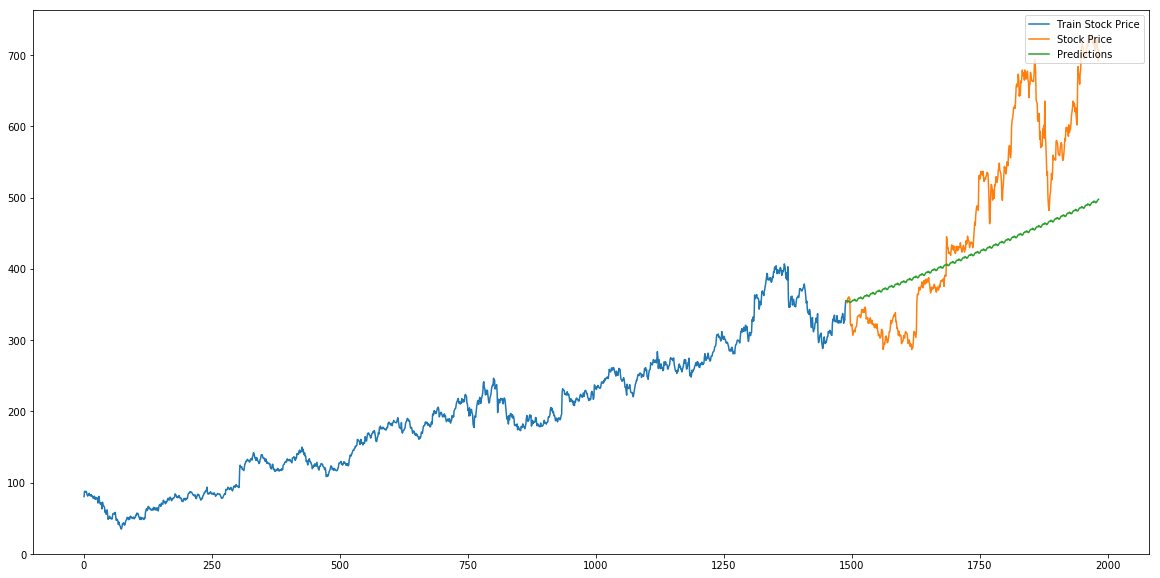

In [47]:
plt.plot(train['Close'], label='Train Stock Price')
plt.plot(valid['Close'], label='Stock Price')
plt.plot(forecast['Prediction'], label='Predictions')
plt.legend(loc='upper right')

In [23]:
# Use Prophet to predict

In [49]:
#importing prophet
from fbprophet import Prophet

#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(df)):
    new_data['Date'][i] = df['Date'][i]
    new_data['Close'][i] = df['adj-close-AMZN'][i]

new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data.index = new_data['Date']

#preparing data
new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = new_data[:train_len]
valid = new_data[train_len:]

#fit the model
model = Prophet()
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/yanjingding/anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [50]:
#rmse
forecast_valid = forecast['yhat'][train_len:]
rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
rms

126.10936117774195

/Users/yanjingding/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/yanjingding/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


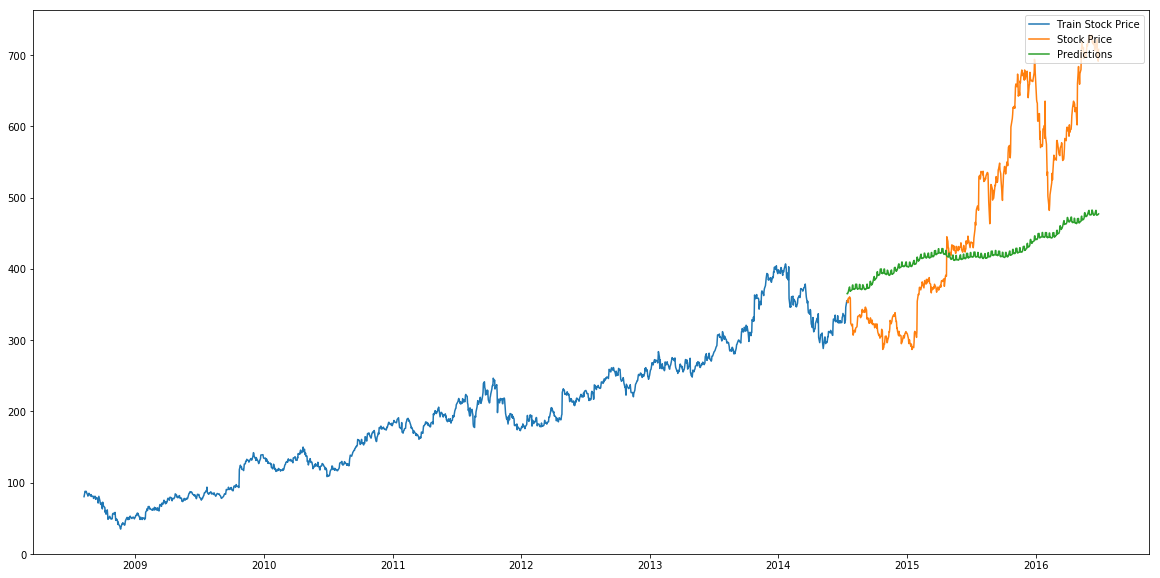

In [52]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = forecast_valid.values

plt.plot(train['y'], label='Train Stock Price')
plt.plot(valid['y'], label='Stock Price')
plt.plot(valid['Predictions'], label='Predictions')
plt.legend(loc='upper right')